# Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from pylab import rcParams
import seaborn as sb

import sklearn
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

# QC with alignment data

### Load data

In [7]:
#alignment with Bowtie 2
#naive T cells, 30 min / 60 min tagmentation time with technical replicates
TN301 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s302_TN301_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)
TN302 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s306_TN302_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)

TN601 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s301_TN601_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)
TN602 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s305_TN602_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)

#activated T cells, 30 min / 60 min tagmentation time with technical replicates
TA301 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s303_TA301_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)
TA302 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s308_TA302_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)

TA601 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s304_TA601_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)
TA602 = pd.read_table('/corgi/lisabeth/ATAC050521/final/s307_TA602_cutadapt_bt2_sorted.bed', sep = '\t', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Name', 'Score', 'Strand'], low_memory=False)


### Mitochondrial contamination

In [169]:
dic = {
        'Sample': ['TN 30.1', 'TN 30.2', 'TN 60.1', 'TN 60.2', 
                   'TA 30.1', 'TA 30.2', 'TA 60.1', 'TA 60.2'],
        'Percentage mt reads': [184470/3706942*100, 
                                563354/11971701*100, 
                                156191/4409090*100, 
                                274847/8228121*100, 
                                50893/5582949*100,
                                55651/5233169*100, 
                                45507/4176993*100, 
                                47548/5697747*100]
        }
    
cont = pd.DataFrame(dic, columns = ['Sample', 'Percentage mt reads'])

cont

,Sample,Percentage mt reads
0,TN 30.1,4.976339
1,TN 30.2,4.705714
2,TN 60.1,3.542477
3,TN 60.2,3.340337
4,TA 30.1,0.911579
5,TA 30.2,1.063428
6,TA 60.1,1.089468
7,TA 60.2,0.834505


### Saturation curves

In [166]:
#define fractions for subsampling = sequencing depth (0, 0.1, 0.2, ..., 1)
frac = [i/10 for i in range(11) if i % 1 == 0]

#function for random subsampling / sequencing depth, returning the according #unique reads
def seq_analysis(df, frac):
    #subsample with given fractions
    dfrandom = df.sample(frac=frac)
    dfdedup = pd.DataFrame.drop_duplicates(dfrandom)
    return dfdedup.shape[0]

#function for plotting
def plotting(df, lab):
    #frac: fractions for subsampling / sequencing depth, y: #unique reads
    frac=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    y = [seq_analysis(df, y) for y in frac]
    
    #generate table for plotting
    table_plotting = pd.DataFrame(
    {
    "Sequencing_depth": frac,
    "Unique_reads": y
    })
    
    #plotting
    plt.plot(table_plotting.Sequencing_depth, table_plotting.Unique_reads, label = lab)
    plt.xlabel('sequencing depth', fontdict={'fontsize':12})
    plt.ylabel('# unique reads', fontdict={'fontsize':12})

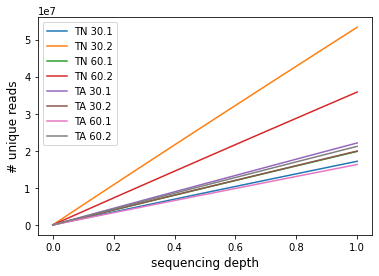

In [170]:
plotting(TN301, lab = 'TN 30.1')
plotting(TN302, lab = 'TN 30.2')
plotting(TN601, lab = 'TN 60.1')
plotting(TN602, lab = 'TN 60.2')
plotting(TA301, lab = 'TA 30.1')
plotting(TA302, lab = 'TA 30.2')
plotting(TA601, lab = 'TA 60.1')
plotting(TA602, lab = 'TA 60.2')

plt.legend()
plt.savefig('saturation_plot.svg')

# QC with peak calling data

In [44]:
#peak calling with homer, technical replicates merged beforehand
TN30 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TN30/peaks.txt', sep = '\t', comment='#', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Strand', 'Normalized Tag Count', 'Focus Ratio', 'Score', 'Fold Change', 'p value', 'x'])
TN60 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TN60/peaks.txt', sep = '\t', comment='#', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Strand', 'Normalized Tag Count', 'Focus Ratio', 'Score', 'Fold Change', 'p value', 'x'])

TA30 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TA30/peaks.txt', sep = '\t', comment='#', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Strand', 'Normalized Tag Count', 'Focus Ratio', 'Score', 'Fold Change', 'p value', 'x'])
TA60 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TA60/peaks.txt', sep = '\t', comment='#', names = ['Chrom', 'ChromStart', 'ChromEnd', 'Strand', 'Normalized Tag Count', 'Focus Ratio', 'Score', 'Fold Change', 'p value', 'x'])


In [84]:
def pt(T):
    #number of peaks in total
    pt = T.shape[0]
    return pt
def ht(T):
    #average score of peaks in total
    ht = T['Score'].mean(axis=0)
    return ht
def pw(T):
    #average peak width in total
    T['Peak width'] = T['ChromEnd'] - T['ChromStart']
    pw = T['Peak width'].mean(axis=0)
    return pw
    
#dictionary
dic = {
        'Sample': ['TN 30', 'TN 60', 'TA 30', 'TA 60'],
        '# Peaks': [pt(TN30), pt(TN60), pt(TA30), pt(TA60)],
        'Percentage peaks': [pt(TN30)/(3707667+11973785)]
        'Av. score': [ht(TN30), ht(TN60), ht(TA30), ht(TA60)],
        'Av. width': [pw(TN30), pw(TN60), pw(TA30), pw(TA60)],
        }
    
df = pd.DataFrame(dic, columns = ['Sample', '# Peaks', 'Av. score', 'Av. width'])
    
df

,Sample,# Peaks,Av. score,Av. width
0,TN 30,335580,21.348859,177.998319
1,TN 60,246117,23.822389,209.998298
2,TA 30,215721,19.630806,201.999105
3,TA 60,177093,17.644147,203.998684


# Peak annotation

In [45]:
#load the genome annotation file
genome = pd.read_csv('/corgi/lisabeth/ATAC050521/ref/Homo_sapiens.GRCh38.104.chr.gtf', comment = "#", sep = "\t", names = ['Chrom', 'source', 'feature', 'Start', 'End', 'score', 'strand', 'frame', 'Attributes'], low_memory=False)
#filter the genome for genes and define their positions
genomed = genome.drop(['source', 'score', 'strand', 'frame'], axis = 1)
genes = genomed[genomed["feature"] == "gene"]
genes['Pos'] = genes[['Start', 'End']].mean(axis=1)

/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
#peak annotation for peaks with score over 50, INCLUDING MT and Y

#function for defining positions of peaks on each chromosome
def positions(T):
    #only peaks with score over 50
    T = T[T['Score'] > 50]
    T['Pos'] = T[['ChromStart', 'ChromEnd']].mean(axis=1)
    #keep only peaks on chromosomes which are also contained in the genome annotation file
    T = T[T['Chrom'].isin(genes["Chrom"].unique())]
    
    peaks = pd.DataFrame(
        {
    "Chrom": T["Chrom"].tolist(),
    "Pos": T["Pos"].tolist(),
    "Score": T["Score"].tolist()
        })
    
    return peaks


#pick the index of the smallest element
def get_index_of_smallest(numbers):
    return numbers.index(min(numbers))


#find the closest gene to one peak position
def closest_gene1(chrom, pos):
    inclchrom = genes[genes["Chrom"] == chrom]
    
    #absolute difference (no neg. values) between gene and peak positions
    diff = abs(inclchrom['Pos'] - pos).tolist()
    #get index of the smallest difference, output fourth column = Attributes (gene name)
    return inclchrom.iloc[get_index_of_smallest(diff),4] 


#find the closest gene to peak positions
def closest_gene_all(T):
    chrom = T["Chrom"].tolist()
    pos = T["Pos"].tolist()
   
    #list comprehension, assignment pos to chrom
    pos_chrom = [closest_gene1(chrom[i], pos[i]) for i in range(0, len(pos))]
    return pos_chrom


def peak_genes(T):
    #include peak positions
    T = positions(T)
    #convert list into a dataframe
    dataframe = pd.DataFrame(closest_gene_all(T), columns = ['Attributes'])
    #split Attributes column at semicolons
    attr = dataframe.Attributes.str.split(";", expand = True)
    #take column of Attributes containing gene names
    gene_name = attr[2]
    
    #generate a dataframe, give gene names (second column of attr)
    table = pd.DataFrame(
        {
    "Chrom": T['Chrom'],
    "Pos": T['Pos'],
    "Peak Score": T['Score'],
    "Gene name": gene_name
        })

    
    #filter column with gene names for gene names only
    onlygn = table[table["Gene name"].str.contains('gene_name')]
    
    #sort dataframe by descending peak scores
    peak_annotation = onlygn.sort_values("Peak Score", ascending = False)
    
    return peak_annotation

In [135]:
#save dataframes as csv files
peak_genes(TN30).to_csv("TN30_peak_annotation_incl")
peak_genes(TN60).to_csv("TN60_peak_annotation_incl")
peak_genes(TA30).to_csv("TA30_peak_annotation_incl")
peak_genes(TA60).to_csv("TA60_peak_annotation_incl")

/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [58]:
#peak annotation for peaks with score over 50 EXCLUDING MT and Y

#function for defining positions of peaks on each chromosome
def positions(T):
    #only peaks with score over 50
    T = T[T['Score'] > 50]
    T['Pos'] = T[['ChromStart', 'ChromEnd']].mean(axis=1)
    #keep only peaks on chromosomes which are also contained in the genome annotation file
    T = T[T['Chrom'].isin(genes["Chrom"].unique())]
    
    peaks = pd.DataFrame(
        {
    "Chrom": T["Chrom"].tolist(),
    "Pos": T["Pos"].tolist(),
    "Score": T["Score"].tolist()
        })
    
    return peaks


#pick the index of the smallest element
def get_index_of_smallest(numbers):
    return numbers.index(min(numbers))


#find the closest gene to one peak position
def closest_gene1(chrom, pos):
    inclchrom = genes[genes["Chrom"] == chrom]
    
    #absolute difference (no neg. values) between gene and peak positions
    diff = abs(inclchrom['Pos'] - pos).tolist()
    #get index of the smallest difference, output fourth column = Attributes (gene name)
    return inclchrom.iloc[get_index_of_smallest(diff),4] 


#find the closest gene to peak positions
def closest_gene_all(T):
    chrom = T["Chrom"].tolist()
    pos = T["Pos"].tolist()
   
    #list comprehension, assignment pos to chrom
    pos_chrom = [closest_gene1(chrom[i], pos[i]) for i in range(0, len(pos))]
    return pos_chrom


def peak_genes2(T):
    #include peak positions
    T = positions(T)
    #convert list into a dataframe
    dataframe = pd.DataFrame(closest_gene_all(T), columns = ['Attributes'])
    #split Attributes column at semicolons
    attr = dataframe.Attributes.str.split(";", expand = True)
    #take column of Attributes containing gene names
    gene_name = attr[2]
    
    #generate a dataframe, give gene names (second column of attr)
    table = pd.DataFrame(
        {
    "Chrom": T['Chrom'],
    "Pos": T['Pos'],
    "Peak Score": T['Score'],
    "Gene name": gene_name
        })

    noMT = table[table["Chrom"]!="MT"]
    noMTorY = noMT[noMT["Chrom"]!="Y"]
    
    #filter column with gene names for gene names only
    onlygn = noMTorY[noMTorY["Gene name"].str.contains('gene_name')]
    
    #sort dataframe by descending peak scores
    peak_annotation = onlygn.sort_values("Peak Score", ascending = False)
    
    return peak_annotation

In [137]:
#save dataframes as csv files
peak_genes2(TN30).to_csv("TN30_peak_annotation_excl")
peak_genes2(TN60).to_csv("TN60_peak_annotation_excl")
peak_genes2(TA30).to_csv("TA30_peak_annotation_excl")
peak_genes2(TA60).to_csv("TA60_peak_annotation_excl")

/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [76]:
#calculate percentage of multiply annotated genes
def uniq(T):
    ug = peak_genes2(T).drop_duplicates(subset=['Gene name']).shape[0]/peak_genes2(T).shape[0]*100
    return ug

dic = {
        'Sample': ['TN 30', 'TN 60', 'TA 30', 'TA 60'],
        'Percentage unique genes': [uniq(TN30), uniq(TN60), uniq(TA30), uniq(TA60)],
        }
df = pd.DataFrame(dic, columns = ['Sample', 'Percentage unique genes'])  

df

/home/mahogny/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Sample,Percentage unique genes
0,TN 30,61.329588
1,TN 60,78.060046
2,TA 30,85.672276
3,TA 60,87.374328


In [79]:
#generate a list with the first 300 DEDUPL gene names of peak annotation EXCL MT and Y
def gene_names_dedup(T):
    gn = peak_genes2(T)
    dedup = gn.drop_duplicates(subset=['Gene name'])
    #remove "gene_names" before actual gene names as well as quotation marks around the gene name
    gn_list = [x.replace("gene_name \"","").replace("\"","") for x in dedup["Gene name"]]
    return print(gn_list[:300])

# Hierarchical clustering

In [40]:
TN301 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TN301.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TN30.1', 4,5,6], low_memory = False)
TN301d = TN301.drop([4, 5, 6], axis=1)
TN302 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TN302.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TN30.2', 4,5,6], low_memory = False)
TN302d = TN302.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)

TN601 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TN601.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TN60.1', 4,5,6], low_memory = False)
TN601d = TN601.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)
TN602 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TN602.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TN60.2', 4,5,6], low_memory = False)
TN602d = TN602.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)

TA301 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TA301.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TA30.1', 4,5,6], low_memory = False)
TA301d = TA301.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)
TA302 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TA302.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TA30.2', 4,5,6], low_memory = False)
TA302d = TA302.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)

TA601 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TA601.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TA60.1', 4,5,6], low_memory = False)
TA601d = TA601.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)
TA602 = pd.read_table('/corgi/lisabeth/ATAC050521/final/homer/TAvsTN/peaksTall_TA602.bed', comment = "#", sep = "\t", names = ['Chrom', 'ChromStart', 'ChromEnd', '# Overlaps TA60.2', 4,5,6], low_memory = False)
TA602d = TA602.drop(["Chrom", "ChromStart", "ChromEnd", 4, 5, 6], axis=1)

m = pd.concat([TN301d, TN302d, TN601d, TN602d, TA301d, TA302d, TA601d, TA602d], axis = 1)

Tg = m[m["Chrom"].str[0]!="G"]
Tk = Tg[Tg["Chrom"].str[0]!="K"]
Tcounts = Tk.drop(["Chrom", "ChromStart", "ChromEnd"], axis=1)

Tcounts['TN 30.1'] = Tcounts['# Overlaps TN30.1']/Tcounts['# Overlaps TN30.1'].sum()
Tcounts['TN 30.2'] = Tcounts['# Overlaps TN30.2']/Tcounts['# Overlaps TN30.2'].sum()
Tcounts['TN 60.1'] = Tcounts['# Overlaps TN60.1']/Tcounts['# Overlaps TN60.1'].sum()
Tcounts['TN 60.2'] = Tcounts['# Overlaps TN60.2']/Tcounts['# Overlaps TN60.2'].sum()
    
Tcounts['TA 30.1'] = Tcounts['# Overlaps TA30.1']/Tcounts['# Overlaps TA30.1'].sum()  
Tcounts['TA 30.2'] = Tcounts['# Overlaps TA30.2']/Tcounts['# Overlaps TA30.2'].sum() 
Tcounts['TA 60.1'] = Tcounts['# Overlaps TA60.1']/Tcounts['# Overlaps TA60.1'].sum()
Tcounts['TA 60.2'] = Tcounts['# Overlaps TA60.2']/Tcounts['# Overlaps TA60.2'].sum()

Tadj = Tcounts.drop(["# Overlaps TN30.1", "# Overlaps TA30.1", "# Overlaps TN60.1", "# Overlaps TA60.1",
                    "# Overlaps TN30.2", "# Overlaps TA30.2", "# Overlaps TN60.2", "# Overlaps TA60.2"], axis=1)
Ttr = Tadj.to_numpy().transpose()

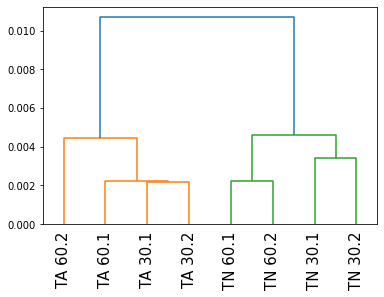

<Figure size 432x288 with 0 Axes>

In [42]:
Tm = linkage(Ttr)

dendrogram(Tm, p = 12, leaf_rotation = 90, leaf_font_size = 15, labels = Tadj.columns)

plt.show()
plt.savefig('dendrogram.svg')